# Метод Прюитт (англ. Prewitt)

**Оператор Прюитт** — метод выделения границ в обработке изображений, который вычисляет максимальный отклик на множестве ядер свёртки для нахождения локальной ориентации границы в каждом пикселе. Он был создан доктором Джудит Прюитт (Judith Prewitt) для обнаружения границ медицинских изображений.

### Описание работы метода

Проще говоря, оператор вычисляет градиент интенсивности изображения в каждой точке, указывая направление максимально возможного увеличения от светлого к темному и скорость изменения в этом направлении. Таким образом, результат показывает, насколько "резко" или "плавно" меняется изображение в этой точке, и, следовательно, насколько вероятно, что часть изображения представляет собой край, а также как этот край, вероятно, будет ориентирован. На практике расчет величины (вероятности края) более надежен и его легче интерпретировать, чем расчет направления.

Математически градиент функции с двумя переменными (здесь функция интенсивности изображения) представляет собой в каждой точке изображения двумерный вектор с компонентами, заданными производными в горизонтальном и вертикальном направлениях. В каждой точке изображения вектор градиента указывает в направлении максимально возможного увеличения интенсивности, а длина вектора градиента соответствует скорости изменения в этом направлении. Это означает, что результатом оператора Прюитта в точке изображения, которая находится в области *постоянной интенсивности изображения, является нулевой вектор*, а в *точке на краю* - вектор, который указывает через край, от более темных значений к более ярким.

### Формулировка оператора

Оператор использует два ядра 3×3, свёртывая исходное изображение для вычисления приближённых значений производных: одно по горизонтали и одно по вертикали. Положим ${\displaystyle \mathbf {A} }$  исходным изображением, и ${\displaystyle \mathbf {G_{x}}}$, ${\displaystyle \mathbf {G_{y}} }$ — двумя изображениями, в которых каждая точка содержит горизонтальное и вертикальное приближение производной, которая рассчитывается как

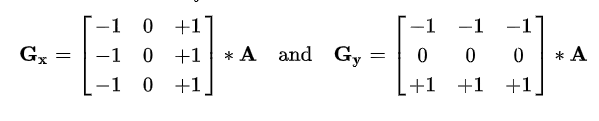

In [10]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import math

Ниже представлена реализация оператора Приюти на языке python с использованием библиотеки openCV

In [71]:
def filter_prewitt(img):
    """
    Функция реализует работу оператора Приютти и возвращает изображение с выделенными границами иглы
    
    img - исходное изображение;
    """
    x = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    y = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    
    img_prewitt_x = cv.filter2D(img, -1, x)
    img_prewitt_y = cv.filter2D(img, -1, y)
    
    img_prewitt = img_prewitt_x + img_prewitt_y
    
    return img_prewitt

In [39]:
def draw_borders(img):
    """
    Функция для отрисовки исходной картинки и границ иглы при помощи фильтра Кэнни
    
    img - исходная картинка
    """
    img_filter = filter_prewitt(img)
    plt.figure(figsize=(13, 13))
    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Черно-белая картинка')
    plt.subplot(122), plt.imshow(img_filter, cmap='gray')
    plt.title('Границы алмазной иглы')
    plt.show()

### Пример 1

Алмазная игла, где кончик иглы четко разлечим
<img src="../dataset/zoom_needle/b_needle_1.jpg" alt="Игла с хорошо выделенными границами без помех" width="200"/>

In [79]:
img_1 = cv.imread('..//dataset/zoom_needle/b_needle_1.jpg', cv.IMREAD_GRAYSCALE)

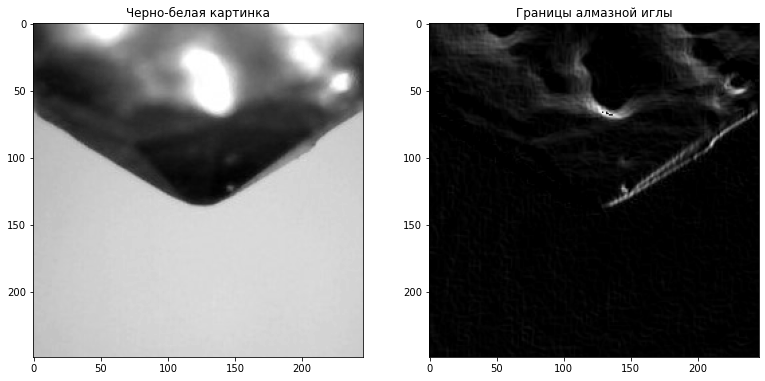

In [80]:
draw_borders(img_1)

#### Повышение контрастности ЧБ изображения
Попробуем улучшить результат работы фильтра, изменяя контрастность черно-белой картинки

In [47]:
def calc_gray_hist(img):
    """
    Функция для расчёта гистограммы распределения серого на картинке
    
    img - исходная картинка
    """
    height, weight = img.shape[:2]
    grayHist = np.zeros([256], np.uint64)
    for i in range(height):
        for j in range(weight):
            grayHist[img[i][j]] += 1
    return grayHist

In [48]:
def gray_hist(img):
    """
    Функция для отрисовки гистограммы распределения серого на картинке
    
    img - исходная картинка
    """
    height, weight = img.shape[:2]
    pixelSequence = img.reshape([height * weight, ])
    numberBins = 256
    histogram, bins, patch = plt.hist(pixelSequence, numberBins,
                                      facecolor='black', histtype='bar')
    plt.xlabel("gray label")
    plt.ylabel("number of pixels")
    plt.axis([0, 255, 0, np.max(histogram)])
    plt.show()

**1. Cпособ улучшения картинки**

***Нормализация гистограммы***

которая представляет собой метод линейного преобразования, который автоматически выбирает значения a и b, где

$a = \frac{O_{max}-O_{min}}{I_{max}-I_{min}},b=O_{min}-\frac{O_{max}-O_{min}}{I_{max}-I_{min}}*I_{min}$,

где 
- $O_{max},O_{min}$ - минимальный уровень серого и максимальный уровень серого, отображаемые в исходном изображении
- $I_{max},I_{min}$- минимальный уровень серого и максимальный уровень серого, заданный самостоятельно

*Замечание:*

Если $a > 1$, коэффициент контрастности выходного изображения увеличивается, если $0 < a < 1$, коэффициент контрастности уменьшается маленький. 

Изменение значения $b$ влияет на яркость выходного изображения. При $b > 0$ яркость увеличивается, а при $b < 0$ яркость уменьшается.

In [49]:
def normaliz_hist(img):
    """
    Функция для нормализации гистограммы распределения серого на картинке
    
    img - исходная картинка
    """
    i_min, i_max = cv.minMaxLoc(img)[:2]
    o_min, o_max = 0, 255
    
     # Рассчитать значения a и b
    a = float(o_max - o_min) / (i_max - i_min)
    b = o_min - a * i_min
    
    out = a * img + b
    out = out.astype(np.uint8)
    return out

**2. Cпособ улучшения картинки**

***Глобальное выравнивание гистограммы***

Реализация выравнивания гистограммы в основном делится на четыре этапа:
1. Рассчитайте гистограмму градаций серого изображения
2. Рассчитать кумулятивную гистограмму серой гистограммы
3. Соотношение между уровнем серого на входе и уровнем серого на выходе
4. Циклически выводить уровень серого каждого пикселя изображения в соответствии с соотношением отображения

Соотношение сопоставления:

$q=\frac{\sum_{k=0}^{p}hist_{I}(k)}{H*W}*256-1$

Где q - выходной пиксель, а p - входной пиксель. 

Можно так понять, $\frac{\sum_{k=0}^{p}hist_{I}(k)}{H*W}$

Этот термин эквивалентен гистограмме совокупной вероятности гистограммы градаций серого (в диапазоне от 0 до 1), а затем увеличивает диапазон до 0–255, чтобы получить пиксели выходного изображения.

In [50]:
def equal_hist(img):
    return cv.equalizeHist(img)

**3. Cпособ улучшения картинки**

***Адаптивная коррекция гистограммы с ограниченным контрастом***

Адаптивное выравнивание гистограммы сначала делит изображение на непересекающиеся региональные блоки, а затем выполняет выравнивание гистограммы для каждого блока отдельно. Очевидно, что при отсутствии шума гистограмма в градациях серого для каждой небольшой области будет ограничена небольшим диапазоном градаций серого, но при наличии шума после выполнения выравнивания гистограммы для каждого блока разделенной области, Шум будет усиливаться. 

Во избежание появления шума предлагается «Ограничение контраста» (Contrast Limiting). Если интервал гистограммы заранее превышает предварительно установленный «предел контраста», он будет обрезан, а затем обрезанная часть будет равномерно распределена между другими Бин, тем самым восстанавливая гистограмму. Далее вводится функция выравнивания адаптивной гистограммы для ограничения контраста, реализованная OpenCV,

In [51]:
def additive_correct(img):
    new_img = cv.resize(img, None, fx=0.5, fy=0.5)
     # Создать объект CLAHE
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    
     # Адаптивное пороговое выравнивание для ограничения контраста
    dst = clahe.apply(new_img)
    return dst

**1. Нормализация гистограммы серого**

*Пример 1*

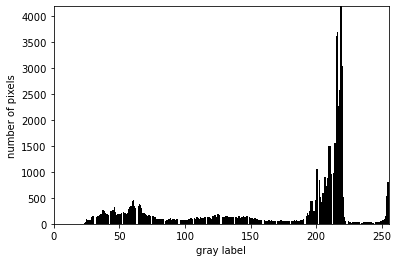

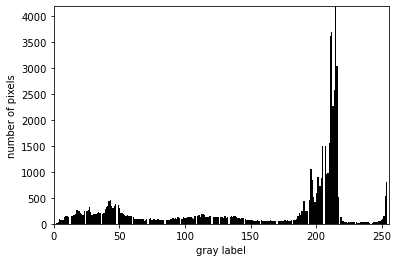

In [55]:
img_1_normaliz = normaliz_hist(img_1)
gray_hist(img_1)
gray_hist(img_1_normaliz)

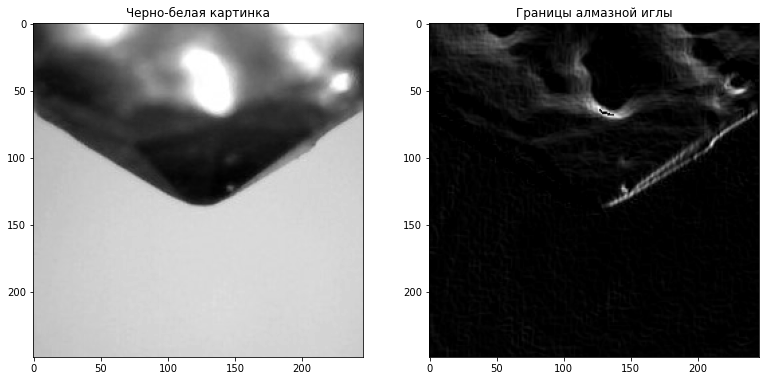

In [56]:
draw_borders(img_1_normaliz)

**2. Глобальное выравнивание гистограммы**

*Пример 1*

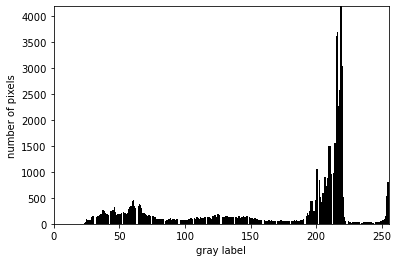

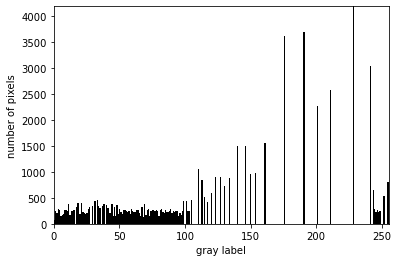

In [58]:
img_1_equal = equal_hist(img_1)
gray_hist(img_1)
gray_hist(img_1_equal)

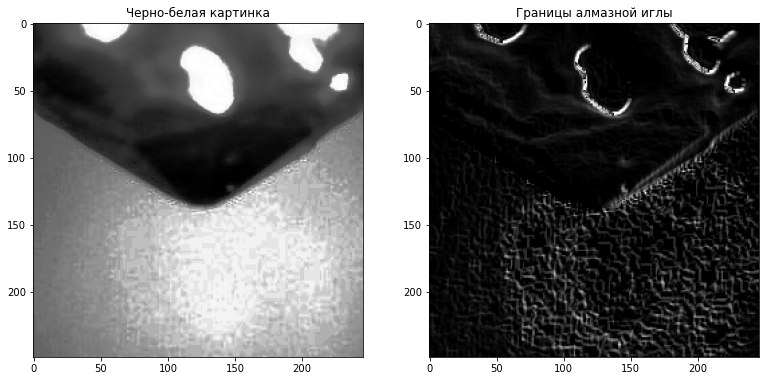

In [59]:
draw_borders(img_1_equal)

**3. Cпособ улучшения картинки**

*Пример 1*

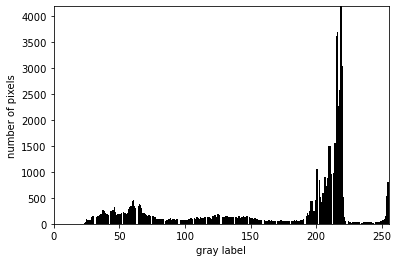

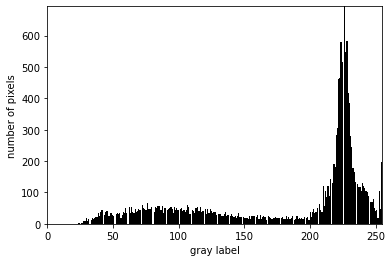

In [60]:
img_1_dst = additive_correct(img_1)
gray_hist(img_1)
gray_hist(img_1_dst) 

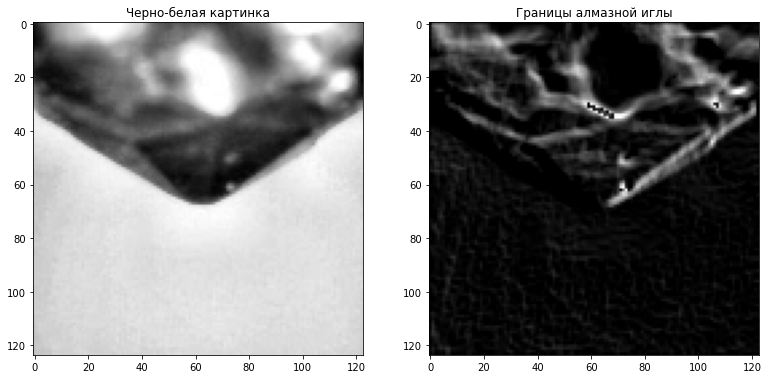

In [61]:
draw_borders(img_1_dst)

### Пример 2

На фоне имеются другие объекты, цвет кончика иглы и фон находятся в одной цветовой гамме

<img src="../dataset/zoom_needle/b_needle_2.jpg" alt="затупленная игла с невыраженными границами" width="200"/>

In [62]:
img_2 = cv.imread('..//dataset/zoom_needle/b_needle_2.jpg', cv.IMREAD_GRAYSCALE)

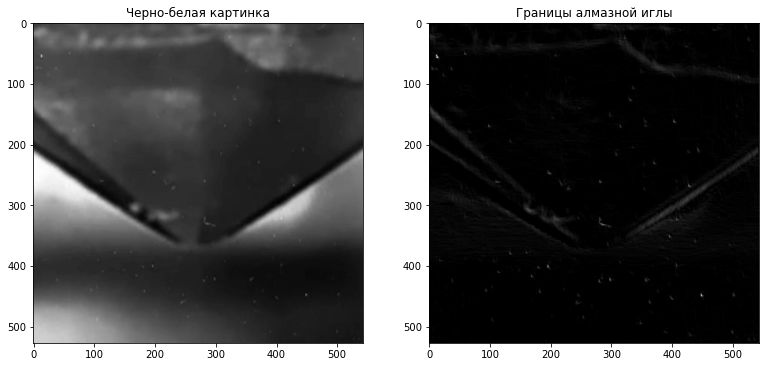

In [63]:
draw_borders(img_2)

**1. Нормализация гистограммы серого**

*Пример 2*

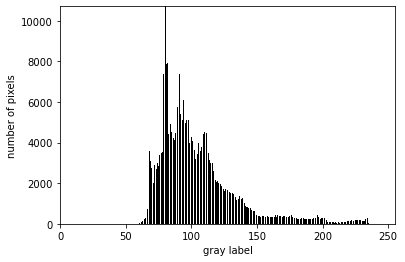

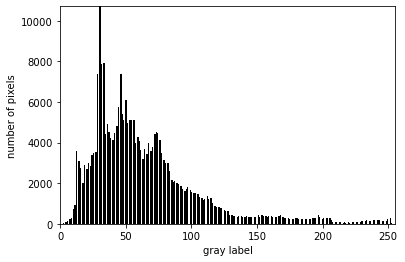

In [73]:
img_2_normaliz = normaliz_hist(img_2)
gray_hist(img_2)
gray_hist(img_2_normaliz)

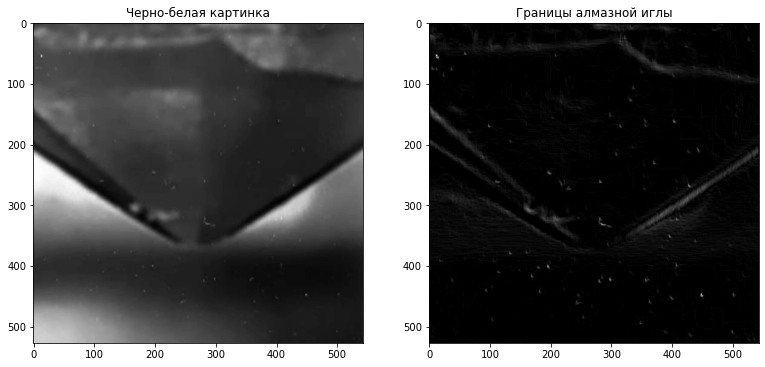

In [74]:
draw_borders(img_2_normaliz)

**2. Глобальное выравнивание гистограммы**

*Пример 2*

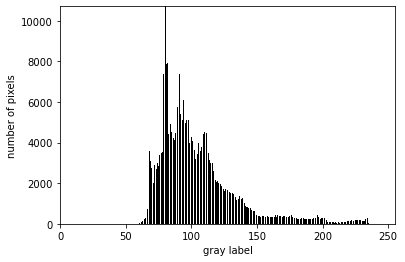

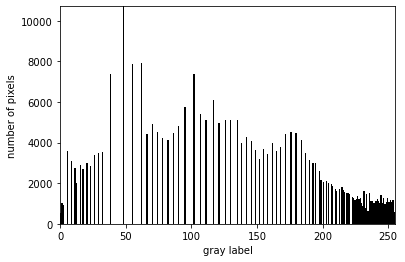

In [75]:
img_2_equal = equal_hist(img_2)
gray_hist(img_2)
gray_hist(img_2_equal)

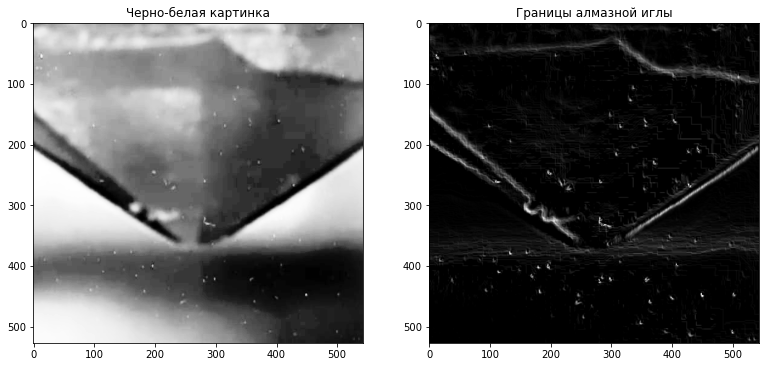

In [76]:
draw_borders(img_2_equal)

**3. Cпособ улучшения картинки**

*Пример 2*

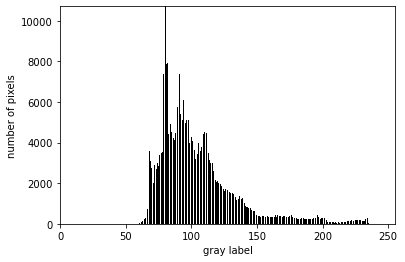

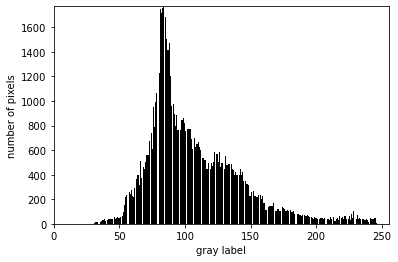

In [77]:
img_2_dst = additive_correct(img_2)
gray_hist(img_2)
gray_hist(img_2_dst)

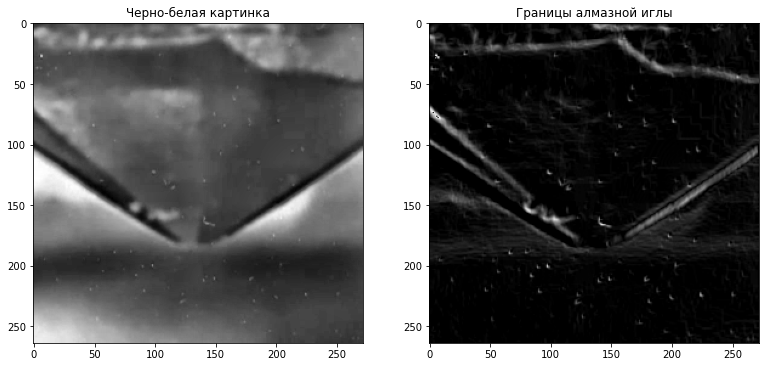

In [78]:
draw_borders(img_2_dst)

**Вывод:** как видно из приведенных примеров и попыток улучшения картинки не вышло ничего хорошего. На картинке, где границы были четко выделены оператор Приютт определяет только одну из линий. На картинке, которая была с помехами виднеются некоторые улучшения в работе оператора, но границы определяются не четко и не верно. 

Данный оператор не подходит для дальнейших исследований.